In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
algos = ['atofigh', 'felerius', 'gabow', 'hollow', 'lemon', 'matrix', 'pq', 'set', 'spaghetti', 'treap', 'yosupo']
colors = {
    'atofigh': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    'felerius': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
     'gabow': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
     'hollow': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
     'lemon': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
     'matrix': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
     'pq': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0),
     'set': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
     'spaghetti': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
     'treap': 'black',
     'yosupo': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
}
marker = {
    'atofigh': '*',
    'felerius': '+',
    'gabow': 'D',
    'hollow': '>',
    'lemon': '2',
    'matrix': 's',
    'pq': '.',
    'set': 'P',
    'spaghetti': 'X',
    'treap': '^',
    'yosupo': 'p',
}
labels = {alg:alg for alg in algos}
labels['gabow'] = 'GGST'

In [4]:
repos = []
for data_set in ['fastestspeedrun', 'konect', 'networkrepository', 'yosupo', 'antilemon', 'girgs']:
    csv_name = f'20220414_results/runtime-{data_set}.csv'
    if not os.path.isfile(csv_name):
        print(data_set, 'missing')
        continue
    repo = pd.read_csv(csv_name, index_col=['file','algo'])
    repo['total'] = repo.con + repo.run + repo.rec + repo['del']
    # fill missing file/algo combinations with -1
    completeIndex = pd.MultiIndex.from_product((repo.index.levels[0],algos),names=repo.index.names)
    repo = repo.reindex(completeIndex, fill_value=-1)
    repo['source'] = data_set
    repos.append(repo)

data = pd.concat(repos)

os.makedirs('temp_plots', exist_ok=True)

In [5]:
timed_out = data[data.n==-1].reset_index()
print('timeouts w/o matrix')
print(timed_out[timed_out.algo!='matrix'][["file","algo"]])

timeouts w/o matrix
                            file     algo
6        konect/dimacs9-CAL.soap  atofigh
9        konect/dimacs9-CTR.soap  atofigh
10       konect/dimacs9-CTR.soap    lemon
12         konect/dimacs9-E.soap  atofigh
15       konect/dimacs9-LKS.soap  atofigh
17        konect/dimacs9-NE.soap  atofigh
21       konect/dimacs9-USA.soap  atofigh
22       konect/dimacs9-USA.soap    lemon
24         konect/dimacs9-W.soap  atofigh
25         konect/dimacs9-W.soap    lemon
163  antilemon/anti1000000.wsoap  atofigh
164  antilemon/anti1000000.wsoap    lemon


felerius 76 0
gabow 177 174
hollow 6 0
lemon 2 1
matrix 50 19
pq 229 1
spaghetti 1 0


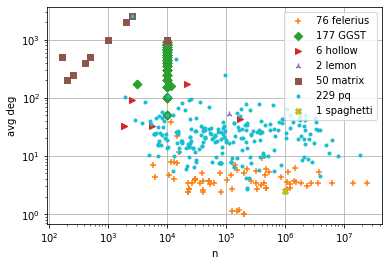

In [6]:
# w/o ties (all not timeout and untied best)
relevant = data[data.n!=-1].groupby('file').filter(lambda grp: (grp.total==grp.total.min()).sum()==1)
fastest = relevant.loc[relevant.groupby('file').total.idxmin()]

fastest['avg deg'] = fastest.m / fastest.n
for algo, grp in fastest.reset_index(level=1).groupby('algo'):
    print(algo, len(grp), len(grp[grp.source=='girgs']))
    plt.gca().scatter(grp['n'], grp['avg deg'], label=f'{len(grp)} {labels[algo]}', color=colors[algo], marker=marker[algo])

plt.loglog()
plt.legend(loc='upper right')
plt.grid()
plt.gca().set_axisbelow(True)
plt.xlabel('n')
plt.ylabel('avg deg')
plt.savefig('temp_plots/fastest.pdf', bbox_inches='tight')

In [7]:
relevant = data[data.n!=-1].groupby('file').filter(
    lambda grp: (grp.total==grp.total.min()).sum()==11 and grp.total.min()==0)
print(len(relevant.groupby('file')))
relevant = data[data.n!=-1].groupby('file').filter(
    lambda grp: (grp.total==grp.total.min()).sum()>1 and grp.total.min()==0)
print(len(relevant.groupby('file')))
relevant = data[data.n!=-1].groupby('file').filter(
    lambda grp: (grp.total==grp.total.min()).sum()>1 and grp.total.min()>0)
print(len(relevant.groupby('file')))
relevant = data[data.n!=-1].groupby('file').filter(
    lambda grp: (grp.total==grp.total.min()).sum()>1)
print(len(relevant.groupby('file')))

46
83
32
115


Text(0, 0.5, 'time in ms')

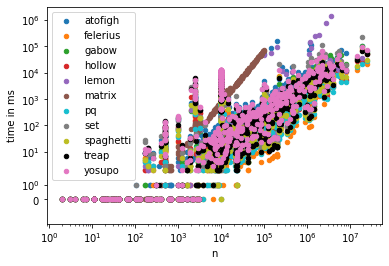

In [8]:
for algo, view in data.groupby('algo'):
    view.plot.scatter('n', 'total', ax=plt.gca(), label=algo, color=colors[algo])
plt.yscale('symlog')
plt.semilogx()
plt.ylabel('time in ms')

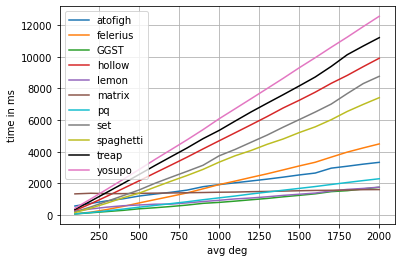

In [9]:
for algo,grp in data[(data.n!=-1) & (data.source=='girgs')].groupby('algo'):
    df = grp.reset_index()
    df['adeg'] = df['file'].str.slice(10,14).astype(int)
    avg_times = df.groupby('adeg').total.mean()
    # plt.plot(grp.m[:-1], grp.total[:-1], label=algo, color=colors[algo])
    plt.plot(avg_times.index.values, avg_times, label=labels[algo], color=colors[algo])

plt.legend()
plt.xlabel('avg deg')
plt.ylabel('time in ms')
plt.grid()
plt.savefig('temp_plots/time_density.pdf', bbox_inches='tight')

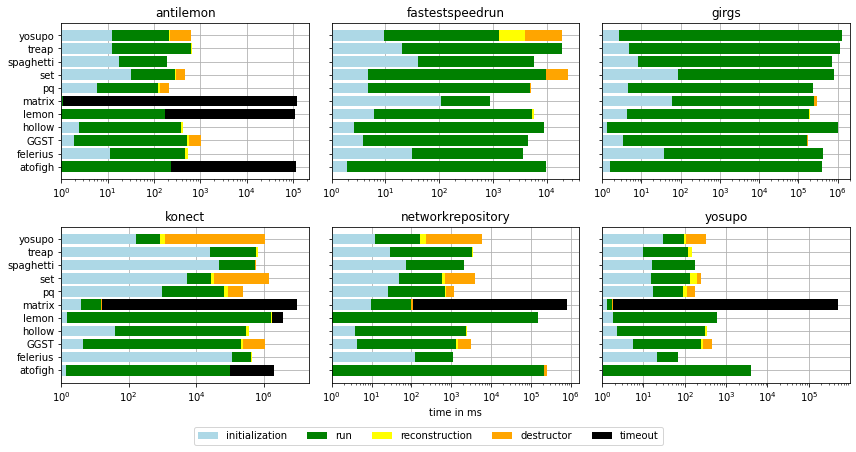

In [15]:
to_plot = [
    ('con', 'initialization','lightblue'), 
    ('run', 'run', 'green'), 
    ('rec','reconstruction', 'yellow'), 
    ('del','destructor', 'orange'),
    ('timeout','timeout', 'black')
]

grps = data.groupby('source')

fig, axs = plt.subplots(nrows=2, ncols=len(grps)//2, sharey=True, figsize=(12,6))
axs = axs.flatten()

for (source, view), ax in zip(grps,axs):
    view = view.copy()
    view['timeout'] = 0
 
    for col in ['run', 'con','rec','del', 'total']:
        view[col].replace(-1,0,inplace=True)
    view.loc[view.n==-1,'timeout'] = 60*1000

    timings = view.groupby(level=1).sum().reset_index()
    timings['total'] += timings['timeout']
    for col in ['run', 'con','rec','del', 'timeout']:
        timings[col] = timings['total'] ** (timings[col] / timings['total'])
    
    timings['offset'] = 1 # log of this is 0
    for column,label,color in to_plot:
        ax.barh(y=timings['algo'], width=timings.offset * timings[column] - timings.offset, left=timings.offset, 
                label=label, tick_label=list(labels.values()), color=color)
        timings['offset'] *= timings[column] # multiplying logs is same as adding in non-log
        
    ax.set_title(source)
    ax.semilogx()
    ax.set_xlim(left=1)
    ax.grid()
    ax.set_axisbelow(True)
    
axs[1].set_xlim(right=4e4)
axs[2].set_xlim(right=2e6)
#axs[5].set_xlim(right=2e8)
#axs[3].legend(loc='lower right', bbox_to_anchor=(2, -0.5), ncol=5)
axs[-2].set_xlabel('time in ms')

# external legend
fig.legend([x[1] for x in to_plot], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
plt.savefig('temp_plots/time_bar.pdf', bbox_inches='tight')